# Введение в нейронные сети

## Эпизод 2: Многослойный персептрон

Дмитрий Сошников | dmitri@soshnikov.com

Данная презентация представляет собой введение в современные нейронные сети на основе Microsoft Cognitive Toolkit (CNTK). Идея однодневного мастер-класса основана на Neural Network Workshop в Microsoft Research Cambridge. Материал и фрагменты кода частично взяты из презентаций [Katja Hoffmann](https://www.microsoft.com/en-us/research/people/kahofman/), [Matthew Johnson](https://www.microsoft.com/en-us/research/people/matjoh/) и [Ryoto Tomioka](https://www.microsoft.com/en-us/research/people/ryoto/) из Microsoft Research Cambridge. [NeuroWorkshop](http://github.com/shwars/NeuroWorkshop) подготовлен [Дмитрием Сошниковым](http://blog.soshnikov.com), Microsoft Russia.

## Обучение с учителем

**Дано:**
  * Обучающая выборка $\mathbf{X} \in \mathbb{R}^{n \times k}$
    * $n$ - размер выборки
    * $x_i$ представлено вектором свойств размерности $k$
  * Известные значения целевой функции $\mathbf{Y}$ ($y_i$ соответствует вектору свойств $x_i$)
    * $\mathbf{Y} \in \mathbb{R}^{n \times 1}$ (задачи регрессии)
    * $\mathbf{Y} \in C^{n \times 1}$, где $y_i \in C$ (задачи классификации на $|C|$ классов)


## Задача

**Дано:**
  * Обучающая выборка $\mathbf{X} \in \mathbb{R}^{n \times k}$
  * Входные значение целевой функции $\mathbf{Y}$

**Необходимо построить:**
  * Функцию $f : \mathbf{X} \rightarrow \mathbf{Y}$ который _точно предсказывает_ значение целевой функции на новом наборе входных данных $\mathbf{X}_{new}$


In [1]:
import matplotlib.pyplot as plt 
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np

In [2]:
# pick the seed for reproducability - change it to explore the effects of random variations
np.random.seed(0)
import random

## Пример
Рассмотрим пример двухмерной задачи классификации на 2 класса. Примером такой задачи может быть классификация опухоли на 2 типа - доброкачественная и злокачественная, в зависимости от её размера и возраста.


In [3]:
n = 100
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.2)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

# Разбиваем на обучающую и тестовые выборки
train_x, test_x = np.split(X, [n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])

In [4]:
def plot_dataset(suptitle, features, labels):
    # prepare the plot
    fig, ax = plt.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')

    colors = ['r' if l else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    fig.show()

/tmp/ipykernel_17453/1441799467.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


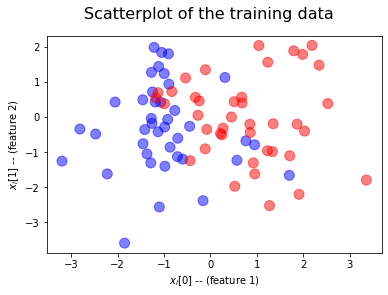

In [5]:
plot_dataset('Scatterplot of the training data', train_x, train_labels)

In [6]:
print(train_x[:5])
print(train_labels[:5])

[[ 1.3382818  -0.98613256]
 [ 0.5128146   0.43299454]
 [-0.4473693  -0.2680512 ]
 [-0.9865851  -0.28692   ]
 [-1.0693829   0.41718036]]
[1 1 0 0 0]


## Подход

  * Задаём функцию потерь (loss function) $\mathcal{L}$
  * Определяем модель $f_{\theta}$ с параметрами $\theta$
  * Подстраиваем $\theta$ для минимизации $\mathcal{L_{\theta}}$ на обучающей выборке
$\theta = \mathrm{argmin}_\theta \mathcal{L_\theta}(X,Y)$
  * Проверяем качество модели на тестовой выборке

Результат: $f_{\theta}$, которая делает предсказания на новых данных: $\hat{Y} = f_{\theta}(X_{new})$

## Функции потерь

* Определяют (формализуют) цель обучения, т.е. фразу _"точно предсказать"_
* Выбор обусловлен требуемыми свойствами (непрерывность, дифференцируемость)

**Часто используемые функции для регрессии**

Абсолютная ошибка: $\mathcal{L}_{abs}(\theta) = \sum_{i=1}^n |y_i - f_{\theta}(x_i)|$

Среднеквадратичная ошибка: $\mathcal{L}_{sq}(\theta) = \sum_{i=1}^n (y_i - f_{\theta}(x_i))^2$


In [7]:
# helper function for plotting various loss functions
def plot_loss_functions(suptitle, functions, ylabels, xlabel):
    fig, ax = plt.subplots(1,len(functions), figsize=(9, 3))
    plt.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle)
    for i, fun in enumerate(functions):
        ax[i].set_xlabel(xlabel)
        if len(ylabels) > i:
            ax[i].set_ylabel(ylabels[i])
        ax[i].plot(x, fun)
    plt.show()

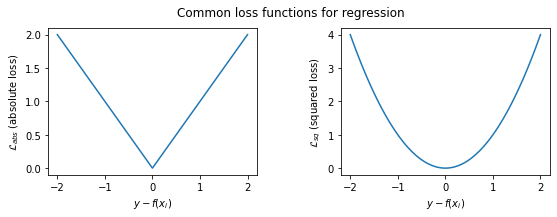

In [8]:
x = np.linspace(-2, 2, 101)
plot_loss_functions(
    suptitle = 'Common loss functions for regression',
    functions = [np.abs(x), np.power(x, 2)],
    ylabels   = ['$\mathcal{L}_{abs}}$ (absolute loss)',
                 '$\mathcal{L}_{sq}$ (squared loss)'],
    xlabel    = '$y - f(x_i)$')

## Функции ошибки для классификации

**0-1 loss**

Предполагается решающая функция вида $\hat{y} = \mathrm{sign}(f_{\theta}(x))$:

$\mathcal{L}_{0-1}(\theta) = \sum_{i=1}^n l_i \quad  l_i = \begin{cases}
         0 & y_i f_{\theta}(x) > 0 \\
         1 & в\ противном\ случае
       \end{cases} \\
$

**логистическая функция ошибки**

$\mathcal{L}_{log}(\theta) = \sum_{i=1}^n \frac{1}{\log(2)} \log(1 + e^{-y_i f_{\theta}(x)})$

In [9]:
# define and vectorize zero-one loss
def zero_one(d):
    if d < 0:
        return 1
    return 0

def logistic_loss(fx):
    # assumes y == 1
    y = 1
    return 1 / np.log(2) * np.log(1 + np.exp(-y * fx))

zero_one_v = np.vectorize(zero_one)

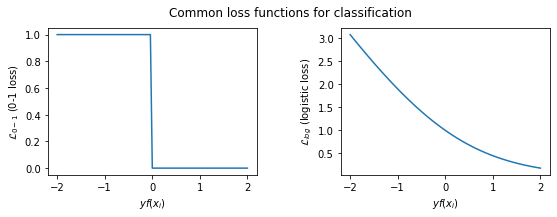

In [10]:
plot_loss_functions(suptitle = 'Common loss functions for classification',
                   functions = [zero_one_v(x), logistic_loss(x)],
                   ylabels    = ['$\mathcal{L}_{0-1}}$ (0-1 loss)',
                                 '$\mathcal{L}_{log}$ (logistic loss)'],
                   xlabel     = '$y f(x_i)$')


## Строим нейросеть
Рассмотрим решение нашей задачи при помощи простейшей однослойной нейросети такого вида:
<img src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/NeuroArch.PNG" width="50%"/>

При этом модель будет описываться как
$$
f_\theta(x) = W\times x + b
$$
где параметры $$\theta = <W,b>$$

In [11]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        
    def forward(self, x):
        return np.dot(x, self.W.T) + self.b
    
net = Linear(2,2)
net.forward(train_x[0:5])

array([[ 1.77202116, -0.25384488],
       [ 0.28370828, -0.39610552],
       [-0.30097433,  0.30513182],
       [-0.8120485 ,  0.56079421],
       [-1.23519653,  0.3394973 ]])

## Переходим к вероятностям
Расширяем нейросетевую модель с помощью функции **softmax**: $\sigma(\mathbf{z}_c) = \frac{e^{z_c}}{\sum_{j \in J} e^{z_j}}$ для  $c \in 1 .. |C|$

<img src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/NeuroArch-softmax.PNG" width="50%">

Можем рассматривать $\sigma(\mathbf{z})$ как распределение вероятности на классах $C$: $q = \sigma(\mathbf{z}_c) = \hat{p}(c | x)$


In [12]:
class Softmax:
    def forward(self,z):
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z

softmax = Softmax()
softmax.forward(net.forward(train_x[0:10]))

array([[0.88348621, 0.11651379],
       [0.66369714, 0.33630286],
       [0.35294795, 0.64705205],
       [0.20216095, 0.79783905],
       [0.17154828, 0.82845172],
       [0.24279153, 0.75720847],
       [0.18915732, 0.81084268],
       [0.17282951, 0.82717049],
       [0.13897531, 0.86102469],
       [0.72746882, 0.27253118]])

## Ещё один взгляд на архитектуру сети

![Архитектура нейросети](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/Cross-Entropy-Loss.PNG)


## Cross-Entropy Loss

* Повсеместно применяется в глубоком обучении
* Основная идея:
    - трактуем выход модели как распределение вероятностей появления того или иного класса
    - минимизируем вероятность неправильной классификации

Два подхода к пониманию Cross-Entropy Loss:
  * Цена ошибки, которую мы платим за неправильную классификацию, т.е. $-\log p_y$, где $y$ - правильный класс
  * Разница между двумя распределениями вероятностей. Энтропия $p$ + KL-расстояние между $q$ и $p$:
$\begin{align} H(p, q) = & ~\color{red}{H(p)} + \color{blue}{D_{KL}(p||q)} \\
    = & ~\color{red}{-\sum_{c \in C} p(c) \log p(c)} + \color{blue}{\sum_{c \in C} p(c) \log \frac{p(c)}{q(c)}} \\
    = & ~-\sum_{c \in C} p(c) \log q(c)
\end{align}$


In [13]:
def plot_cross_ent():
    p = np.linspace(0.01, 0.99, 101) # estimated probability p(y|x)
    cross_ent_v = np.vectorize(cross_ent)
    f3, ax = plt.subplots(1,1, figsize=(8, 3))
    l1, = plt.plot(p, cross_ent_v(p, 1), 'r--')
    l2, = plt.plot(p, cross_ent_v(p, 0), 'r-')
    plt.legend([l1, l2], ['$y = 1$', '$y = 0$'], loc = 'upper center', ncol = 2)
    plt.xlabel('$\hat{p}(y|x)$', size=18)
    plt.ylabel('$\mathcal{L}_{CE}$', size=18)
    plt.show()

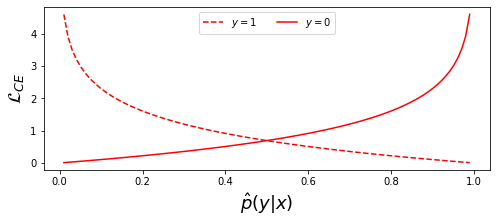

In [14]:
def cross_ent(prediction, ground_truth):
    t = 1 if ground_truth > 0.5 else 0
    return -t * np.log(prediction) - (1 - t) * np.log(1 - prediction)
plot_cross_ent()

In [15]:
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()

cross_ent_loss = CrossEntropyLoss()
p = softmax.forward(net.forward(train_x[0:10]))
cross_ent_loss.forward(p,train_labels[0:10])

1.429664938969559

## Задача минимизации
Описав нейронную сеть как модель $f_\theta$ и функцию ошибки $\mathcal{L}(Y,f_\theta(X))$, можем рассмотреть $\mathcal{L}$ как функцию $\theta$ на всем множестве обучающей выборки $\mathcal{L}(\theta) = \mathcal{L}(Y,f_\theta(X))$

В этом случае задача обучения сети будет формулироваться как задача минимизации $\mathcal{L}$ по $\theta$:
$$
\theta = \mathrm{argmin}_{\theta} \mathcal{L}(Y,f_\theta(X))
$$

Минимизацию можно осуществлять разными методами, например, стохастическим градиентным спуском (stochastic gradient descent, SGD)

## Реализация нейронных сетей

 * Вручную
 * С использованием готовых фреймворков
     - PyTorch
     - Tensorflow
     - Chainer
     - [Microsoft Cognitive Toolkit](http://cntk.ai)

## Вычислительный граф

<img src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/ComputeGraph.PNG" width="600px"/>


In [16]:
z = net.forward(train_x[0:10])
p = softmax.forward(z)
loss = cross_ent_loss.forward(p,train_labels[0:10])
print(loss)

1.429664938969559


## Обучение сети

  * Для обучения сети необходимо предъявлять ей примеры, считать ошибку и подстраивать коэффициенты
  * В соответствии с принципом градиентного спуска, необходимо расчитывать изменение коэффициентов в соответствии с градиентом функции $\nabla f_\theta$
  * Итерация обучения выглядит так:
 $$\begin{align}\def\L{\mathcal{L}}
 W^{i+1}&=W^i-\eta\frac{\partial\L}{\partial W}\cr
 b^{i+1}&=b^i-\eta\frac{\partial\L}{\partial b}
 \end{align}
 $$

## Обратное распространение ошибки

<img src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/ComputeGraph.PNG" width="300px" align="left"/>

$$\def\zz#1#2{\frac{\partial#1}{\partial#2}}
\begin{align}
\zz{\L}{W} =& \zz{\L}{p}\zz{p}{z}\zz{z}{W}\cr
\zz{\L}{b} =& \zz{\L}{p}\zz{p}{z}\zz{z}{b}
\end{align}
$$

## Обратное распространение ошибки

<img src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/ComputeGraphGrad.PNG" width="400px" align="right"/>

   * Не повторяем одинаковые вычисления
   * Вычисляем ошибку на каждом узле начиная с конца
   * Обратное распространение ошибки
   * Все вычисления фреймворк берёт на себя

### Реализация обратного распространения

* К каждому узлу добавляем функцию `backward`, которая вычисляет производную и значение ошибки
* После вычисления производных, реализуем обновление весов в соответствии с формулой выше

Например, для линейного узла $z = x\times W+b$:
$$\begin{align}
\frac{\partial z}{\partial W} &= x \\
\frac{\partial z}{\partial b} &= 1 \\
\end{align}$$

Соответственно, если на вход пришла ошибка $\Delta z$, то изменения весов вычисляются так:
$$\begin{align}
\Delta x &= \Delta z \times W \\
\Delta W &= \frac{\partial z}{\partial W} \Delta z = \Delta z \times x \\
\Delta b &= \frac{\partial z}{\partial b} \Delta z = \Delta z \\
\end{align}$$

**ВАЖНО:** Вычисления производятся не для одного элемента обучающей выборки, а сразу для целой последовательности, называемой **minibatch**. Необходимые значения градиентов $\Delta W$ и $\Delta b$ вычисляются по всей выборке, а вектора имеют соответствующую размерность: $x\in\mathbb{R}^{\mathrm{minibatch}\, \times\, \mathrm{nclass}}$

In [17]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

Аналогичный образом функции обратного распространения `backward` добавляются к другим составляющим вычислительного графа:

In [18]:
class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)
    
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p

Теперь напишем цикл обучения модели на нашем датасете. Будем рассматривать один проход по модели - т.н. **эпоху**

In [19]:
lin = Linear(2,2)
softmax = Softmax()
cross_ent_loss = CrossEntropyLoss()

pred = np.argmax(lin.forward(train_x),axis=1)
acc = (pred==train_labels).mean()
print("Initial accuracy: ",acc)

batch_size=4
for i in range(0,len(train_x),batch_size):
    xb = train_x[i:i+batch_size]
    yb = train_labels[i:i+batch_size]
    
    # forward pass
    z = lin.forward(xb)
    p = softmax.forward(z)
    loss = cross_ent_loss.forward(p,yb)
    
    # backward pass
    dp = cross_ent_loss.backward(loss)
    dz = softmax.backward(dp)
    dx = lin.backward(dz)
    lin.update(0.1)
    
pred = np.argmax(lin.forward(train_x),axis=1)
acc = (pred==train_labels).mean()
print("Final accuracy: ",acc)
    

Initial accuracy:  0.725
Final accuracy:  0.825


Для удобства опишем класс, который позволяет объединять узлы вычислительного графа в единую сеть, и применять функции `forward` и `backward` сразу ко всей сети последовательно:

In [20]:
class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)

Ещё раз пробуем создать и обучить нашу нейросеть:

In [29]:
net = Net()
net.add(Linear(2,2))
net.add(Softmax())
loss = CrossEntropyLoss()

def get_loss_acc(x,y,loss=CrossEntropyLoss()):
    p = net.forward(x)
    l = loss.forward(p,y)
    pred = np.argmax(p,axis=1)
    acc = (pred==y).mean()
    return l,acc

print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(train_x,train_labels)))

def generate_batches(X, y, batch_size):
    """
    X: np.array[n_objects, n_features] --- features
    y: np.array[n_objects] --- target
    """
    assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))

    for batch_start in range(0, len(X) - len(X) % batch_size, batch_size):
        indices_list = perm[batch_start : batch_start + batch_size]
        X_batch = [elem1 for elem1 in [X[j] for j in indices_list]]
        y_batch = [elem for elem in [y[i] for i in indices_list]]
        yield (X_batch, y_batch)

def train_epoch(net, train_x, train_labels, loss=CrossEntropyLoss(), batch_size=4, lr=0.1):
    dataloader = generate_batches(train_x, train_labels, batch_size)
    
    for x_batch, y_batch in dataloader:
        p = net.forward(xb)
        l = loss.forward(p,yb)
        dp = loss.backward(l)
        dx = net.backward(dp)
        net.update(lr)
 
train_epoch(net,train_x,train_labels)
        
print("Final loss={}, accuracy={}: ".format(*get_loss_acc(train_x,train_labels)))
print("Test loss={}, accuracy={}: ".format(*get_loss_acc(test_x,test_labels)))

Initial loss=1.1792479900474269, accuracy=0.2125: 
Final loss=0.8465017086794223, accuracy=0.525: 
Test loss=0.9274276655384737, accuracy=0.7: 


In [22]:
def train_and_plot(n_epoch, net, loss=CrossEntropyLoss(), batch_size=4, lr=0.1):
    fig, ax = plt.subplots(2, 1)
    ax[0].set_xlim(0, n_epoch + 1)
    ax[0].set_ylim(0,1)

    train_acc = np.empty((n_epoch, 3))
    train_acc[:] = np.NAN
    valid_acc = np.empty((n_epoch, 3))
    valid_acc[:] = np.NAN

    for epoch in range(1, n_epoch + 1):

        train_epoch(net,train_x,train_labels,loss,batch_size,lr)
        tloss, taccuracy = get_loss_acc(train_x,train_labels,loss)
        train_acc[epoch-1, :] = [epoch, tloss, taccuracy]
        vloss, vaccuracy = get_loss_acc(test_x,test_labels,loss)
        valid_acc[epoch-1, :] = [epoch, vloss, vaccuracy]
        
        ax[0].set_ylim(0, max(max(train_acc[:, 2]), max(valid_acc[:, 2])) * 1.1)

        plot_training_progress(train_acc[:, 0], (train_acc[:, 2],
                                                 valid_acc[:, 2]), fig, ax[0])
        plot_decision_boundary(net, fig, ax[1])
        fig.canvas.draw()
        fig.canvas.flush_events()

    return train_acc, valid_acc

In [23]:
import matplotlib.cm as cm

def plot_decision_boundary(net, fig, ax):
    draw_colorbar = True
    # remove previous plot
    while ax.collections:
        ax.collections.pop()
        draw_colorbar = False

    # generate countour grid
    x_min, x_max = train_x[:, 0].min() - 1, train_x[:, 0].max() + 1
    y_min, y_max = train_x[:, 1].min() - 1, train_x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    grid_points = np.c_[xx.ravel().astype('float32'), yy.ravel().astype('float32')]
    n_classes = max(train_labels)+1
    while train_x.shape[1] > grid_points.shape[1]:
        # pad dimensions (plot only the first two)
        grid_points = np.c_[grid_points,
                            np.empty(len(xx.ravel())).astype('float32')]
        grid_points[:, -1].fill(train_x[:, grid_points.shape[1]-1].mean())

    # evaluate predictions
    prediction = np.array(net.forward(grid_points))
    # for two classes: prediction difference
    if (n_classes == 2):
        Z = np.array([0.5+(p[0]-p[1])/2.0 for p in prediction]).reshape(xx.shape)
    else:
        Z = np.array([p.argsort()[-1]/float(n_classes-1) for p in prediction]).reshape(xx.shape)
    
    # draw contour
    levels = np.linspace(0, 1, 40)
    cs = ax.contourf(xx, yy, Z, alpha=0.4, levels = levels)
    if draw_colorbar:
        fig.colorbar(cs, ax=ax, ticks = [0, 0.5, 1])
    c_map = [cm.jet(x) for x in np.linspace(0.0, 1.0, n_classes) ]
    colors = [c_map[l] for l in train_labels]
    ax.scatter(train_x[:, 0], train_x[:, 1], marker='o', c=colors, s=60, alpha = 0.5)

In [24]:
def plot_training_progress(x, y_data, fig, ax):
    styles = ['k--', 'g-']
    # remove previous plot
    while ax.lines:
        ax.lines.pop()
    # draw updated lines
    for i in range(len(y_data)):
        ax.plot(x, y_data[i], styles[i])
    ax.legend(ax.lines, ['training accuracy', 'validation accuracy'],
              loc='upper center', ncol = 2)

<IPython.core.display.Javascript object>


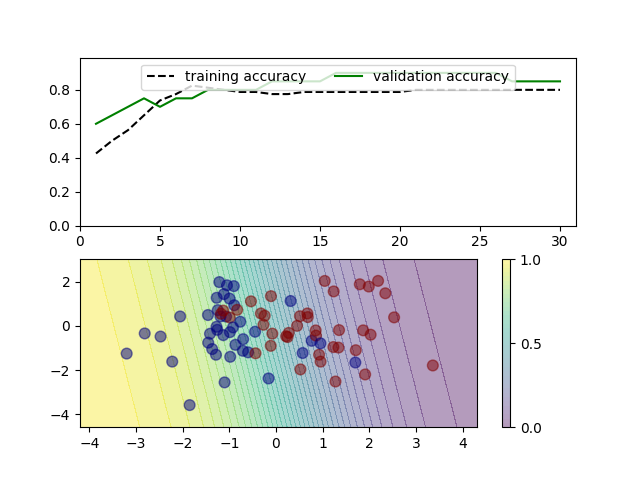

In [25]:
%matplotlib nbagg 

net = Net()
net.add(Linear(2,2))
net.add(Softmax())

res = train_and_plot(30,net,lr=0.005)

## Многослойная модель

  * С нашей архитектурой вычислительного графа легко описывать многослойные персептроны!
  * Нельзя забывать про передаточную функцию (мы будем использовать `tanh`)
  * В более глубоких сетях очень важна первоначальная активация весов

In [30]:
class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy

In [31]:
net = Net()
net.add(Linear(2,5))
net.add(Tanh())
net.add(Linear(5,2))
net.add(Softmax())
loss = CrossEntropyLoss()

<IPython.core.display.Javascript object>


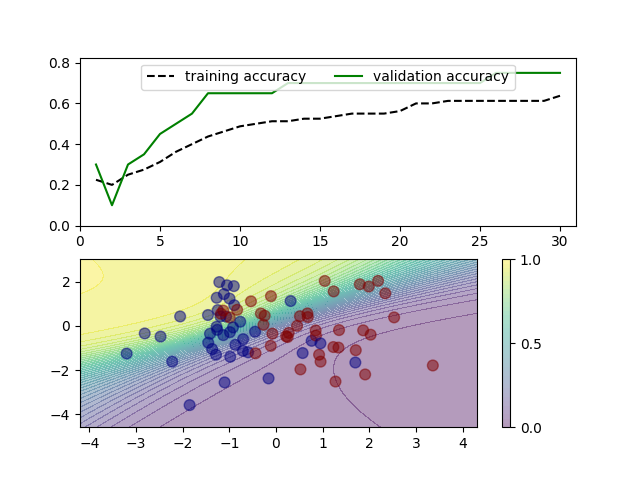

In [32]:
res = train_and_plot(30,net,lr=0.01)

## Важное замечание

Простая линейная модель 
* высокий training loss - "недообучение", выразительности модели не хватает, чтобы разделить данные
* valiadation loss и training loss примерно совпадают - модель хорошо обобщается

Сложная многослойная модель
* низкий training loss - почти идеально приближает обучающую выборку (но может переобучиться)
* validation loss >> training loss и может возрастать - плохо обобщает данные

## Выводы

* Простые модели с небольшим числом параметров ("low capacity") менее склонные к переобучению
* Более сложные модели (high capacity) могут переобучиться (надо следить за validation error)
* Для более сложных моделей необходимо иметь больше данных
* "bias-variance trade-off" - необходимо достичь компромисса между недообучением и переобучением (обучением на распознавание нерелевантного шума во входных данных)